# Implementation of Tamura features based CBIR system
---


**Author:** Abhishek Singh  

**Reg No:** 15BCE1009

**Prof:** Dr Geetha

**Description:** Six Tamura features used for the Content Based Image Retrieval System
___

## Import Libraries

In [21]:
from scipy.signal import find_peaks_cwt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from skimage import io
from skimage.feature import greycomatrix
import os
import scipy as sp
import numpy as np
import pandas as pd

%matplotlib inline

## Path for Image

Loaded 53 images from tamura/ 
Displaying a sample...


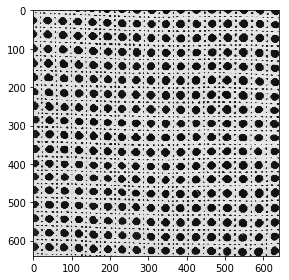

In [20]:
img_path = 'tamura/'
images, filenames = load_image_dir(img_path)
print('Loaded {} images from {} \nDisplaying a sample...'.format(len(images), img_path))
io.imshow(images[10])

##  Features Detection

### Coarseness as a feature

In [23]:
def calculate_coarseness(img):
    [r,c] = img.shape
    G = np.copy(img)
    #initialization
    #Average of neighbouring pixels
    A1=np.zeros([r,c])
    A2=np.zeros([r,c])
    A3=np.zeros([r,c])
    A4=np.zeros([r,c])
    A5=np.zeros([r,c])
    A6=np.zeros([r,c])
    #Sbest for coarseness
    Sbest=np.zeros([r,c])
    #Subtracting for Horizontal and Vertical case
    E1h=np.zeros([r,c])
    E1v=np.zeros([r,c])
    E2h=np.zeros([r,c])
    E2v=np.zeros([r,c])
    E3h=np.zeros([r,c])
    E3v=np.zeros([r,c])
    E4h=np.zeros([r,c])
    E4v=np.zeros([r,c])
    E5h=np.zeros([r,c])
    E5v=np.zeros([r,c])
    E6h=np.zeros([r,c])
    E6v=np.zeros([r,c])
    # to avoid errors
    flag=0
    
    #2x2  E1h and E1v
    #subtracting average of neighbouring 2x2 pixels 
    for x in range(1,r):
        for y in range(1,c):
            A1[x,y] = np.sum(np.sum(G[x-1:x,y-1:y]))
    for x in range(1,r-1):
        for y in range(1,c-1):
            E1h[x,y] = A1[x+1,y] - A1[x-1,y]
            E1v[x,y] = A1[x,y+1] - A1[x,y-1]
    E1h = E1h/2**(2*1)
    E1v = E1v/2**(2*1)
     
    # 4x4  E2h and E2v
    if (r<4 or c<4):
        flag=1
        
    #subtracting average of neighbouring 4x4 pixels
    if flag is 0:
        for x in range(2,r-1):
            for y in range(2,c-1):
                A2[x,y]= np.sum(np.sum(G[x-2:x+1,y-2:y+1]))
        for x in range(2,r-2):
            for y in range(2,c-2):
                E2h[x,y] = A2[x+2,y] - A2[x-2,y]
                E2v[x,y] = A2[x,y+2] - A2[x,y-2]
    E2h = E2h/2**(2*2)
    E2v = E2v/2**(2*2)
    
    #8x8 E3h and E3v
    if r<8 or c<8:
        flag=1
    #subtracting average of neighbouring 8x8 pixels
    if flag is 0:
        for x in range(4,r-3):
            for y in range(4,c-3):
                A3[x,y]=np.sum(np.sum(G[x-4:x+3,y-4:y+3]))
        for x in range(4,r-4):
            for y in range(4,c-4):
                E3h[x,y] = A3[x+4,y]-A3[x-4,y]
                E3v[x,y] = A3[x,y+4]-A3[x,y-4]
    
    E3h=E3h/2**(2*3)
    E3v=E3v/2**(2*3)
    
    #at each point pick best size "Sbest", which gives highest output value
    for i in range(r):
        for j in range(c):
            maxv = np.max([np.abs(E1h[i,j]),np.abs(E1v[i,j]),np.abs(E2h[i,j]),np.abs(E2v[i,j]),np.abs(E3h[i,j]),np.abs(E3v[i,j])])
            index = np.argmax([np.abs(E1h[i,j]),np.abs(E1v[i,j]),np.abs(E2h[i,j]),np.abs(E2v[i,j]),np.abs(E3h[i,j]),np.abs(E3v[i,j])])
            #'k'corresponding to highest E in either direction
            k=np.floor((index+1)/2)
            Sbest[i,j]=2**k

    # Coarseness Value
    Fcoarseness=np.sum(np.sum(Sbest))/(r*c)
    return Fcoarseness

In [11]:
calculate_coarseness(images[0])

5.1241943359375002

### Directionality as a feature

In [25]:
def get_directionality(img):
    r, c = img.shape
    G = np.copy(img)
    # for measuring horizontal differences
    PrewittH = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    # for measuring vertical differences
    PrewittV = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    # Applying PerwittH operator
    deltaH=np.zeros(img.shape)
    for i in range(1,r-1):
        for j in range(1,c-1):
            deltaH[i,j]= np.sum(np.sum(G[i-1:i+2,j-1:j+2]*PrewittH))

    # Modifying borders
    for j in range(1,c-1):
        deltaH[0,j]=G[0,j+1]-G[0,j]
        deltaH[r-1,j]=G[r-1,j+1]-G[r-1,j]  
    for i in range(0,r):
        deltaH[i,1]=G[i,2]-G[i,1]
        deltaH[i,c-1]=G[i,c-1]-G[i,c-2]  

    # Applying PerwittV operator
    deltaV=np.zeros(img.shape)
    for i in range(1,r-1):
        for j in range(1,c-1):
            deltaV[i,j]=np.sum(np.sum(G[i-1:i+2,j-1:j+2]*PrewittV))
        
    # Modifying borders
    for j in range(0,c):
        deltaV[0,j-1]=G[1,j-1]-G[0,j-1]
        deltaV[r-1,j-1]=G[r-1,j-1]-G[r-2,j-1]  
    for i in range(2,r-1):
        deltaV[i-1,0]=G[i,0]-G[i-1,0]
        deltaV[i-1,c-1]=G[i,c-1]-G[i-1,c-1]  
        
    # Magnitude
    deltaG=(np.abs(deltaH)+np.abs(deltaV))/2

    # Local edge direction (0<=theta<pi)
    theta=np.zeros(img.shape)
    for i in range(0,r):
        for j in range(0,c):
            if deltaH[i,j]==0 and deltaV[i,j]==0:
                theta[i,j]=0
            elif deltaH[i,j]==0:
                theta[i,j]=np.pi           
            else:          
                theta[i,j]=np.arctan(deltaV[i,j]/deltaH[i,j]) + np.pi/2

    deltaGt = np.copy(deltaG)
    theta1=np.copy(theta)

    # Set a Threshold value for delta G
    n = 16
    HD = np.zeros([n])
    Threshold=12
    counti=0
    for m in range(-1,(n-1)):
        countk=0
        for k in range(0,len(deltaGt)):
            if ((np.any(deltaGt[k])>=Threshold)
                and (np.any(theta1[k])>=(2*m-1)*np.pi/(2*n))
                and (np.any(theta1[k])<(2*m+1)*np.pi/(2*n))):
                countk=countk+1
                counti=counti+1
        HD[m+1] = countk
    HDf = HD/counti
    
    # peakdet function to find peak values
    #m, p = octave.peakdet(sig=HDf,th=0.000005)
    #(m, p, pidx, didx) = octave.peakdet(sig=HDf)
    m = find_peaks_cwt(HDf, np.arange(1,2))
    Fd=0
    for NP in range(0, len(m)):
        phaiP=m[NP]*(np.pi/n)
        for phi in range(0,len(HDf)):
                Fd=Fd+(phi*(np.pi/n)-phaiP)^2*HDf(phi);

    r = 1/n
    Fdirection = 1 - r*len(m)*Fd
    return Fdirection

### Peak Detection Utility

In [9]:
def peakdet_(sig=None,th=None,typ=None,mdist=None,*args,**kwargs):

    pks=np.array([])
    dep=np.array([])
    pid=np.array([])
    did=np.array([])
    m,n=np.shape(sig)
    
    if m == 1 and n > 1:
        sig=sig.T
        m,n=np.shape(sig)



    if len(th) > 1:
        raise ValueError('Input argument th (threshold) must be a scalar')
    if th <= 0:
        raise ValueError('Input argument th (threshold) must be positive')
    if typ is not None and var is not None:
        typ='threshold'
    if mdist is not None and var is not None:
        mdist=0
    if type(typ) is not str:
        raise ValueError('Input argument type must be string "threshold" or "zero"')
    if strcmp_(_type,char('threshold')) or strcmp_(_type,char('th')):
        cross=copy_(th)
    else:
        if strcmp_(_type,char('zero')):
            cross=0
        else:
            error_(char('Input argument type must be string "threshold" or "zero"'))
    mn=copy_(Inf)
    mx=- Inf
    mnpos=copy_(NaN)
    mxpos=copy_(NaN)
    idx=find_(sig > th,1,char('first'))
    idn=find_(sig < th,1,char('first'))
    if idx < idn:
        lookpks=copy_(true)
    else:
        lookpks=copy_(false)
    for ii in arange_(1,m).reshape(-1):
        this=sig[ii]
        if this > mx:
            mx=copy_(this)
            mxpos=copy_(ii)
        if this < mn:
            mn=copy_(this)
            mnpos=copy_(ii)
        if lookpks:
            if this < cross:
                if mx >= th:
                    pks=matlabarray([[pks],[mx]])
                    pid=matlabarray([[pid],[mxpos]])
                mn=copy_(this)
                mnpos=copy_(ii)
                lookpks=copy_(false)
        else:
            if this > - cross:
                if mn <= - th:
                    dep=matlabarray([[dep],[mn]])
                    did=matlabarray([[did],[mnpos]])
                mx=copy_(this)
                mxpos=copy_(ii)
                lookpks=copy_(true)
    if lookpks:
        if mx >= th:
            pks=matlabarray([[pks],[mx]])
            pid=matlabarray([[pid],[mxpos]])
    else:
        if mn <= - th:
            dep=matlabarray([[dep],[mn]])
            did=matlabarray([[did],[mnpos]])
    if (mdist > 0):
        val,subidx=sort_(pks,char('descend'),nargout=2)
        idx=pid[subidx]
        todelete=false_(size_(val))
        N=length_(val)
        for ii in arange_(1,N).reshape(-1):
            if not todelete[ii]:
                d=arrayfun_(lambda x: norm_(x - idx[ii]),idx)
                todelete=todelete or (d < mdist)
                todelete[ii]=false
        pks[subidx[todelete]]=[]
        pid[subidx[todelete]]=[]
        val,subidx=sort_(dep,nargout=2)
        idx=did[subidx]
        todelete=false_(size_(val))
        N=length_(val)
        for ii in arange_(1,N).reshape(-1):
            if not todelete[ii]:
                d=arrayfun_(lambda x: norm_(x - idx[ii]),idx)
                todelete=todelete or (d < mdist)
                todelete[ii]=false
        dep[subidx[todelete]]=[]
        did[subidx[todelete]]=[]
    return pks,dep,pid,did

### Contrast as a feature

In [24]:
def calculate_contrast(img):
    flat_img = img.ravel()
    std = np.std(flat_img)
    kurtosis = sp.stats.moment(flat_img, moment=4)
    contrast = std/((kurtosis/std**4)**0.25)
    return contrast

In [13]:
calculate_contrast(images[0])

74.519604177924009

## Images loading function

In [8]:
def load_image_dir(path):
    images = []
    filenames = []
    for filename in os.listdir(path):
        filenames.append(os.path.join(path,filename))
        img = io.imread(os.path.join(path,filename))
        if img is not None:
            images.append(img)
    return images, filenames

## Tamura Feature Generation

In [15]:
feature_set = pd.DataFrame(columns=['Image', 'Coarseness','Contrast', 'Directionality'])
for img, name in zip(images, filenames):
    row = {'Image': name,
          'Coarseness': calculate_coarseness(img),
          'Contrast': calculate_contrast(img),
          'Directionality': get_directionality(img),}
    print('Processed Image {}'.format(name), end='\r')
    feature_set = feature_set.append(row, ignore_index=True)
print('Done')

Doneessed Image tamura/D111.gif


## Visualizations

In [16]:
from IPython.core.display import display, HTML
feature_set.loc[:,'Image'] = ["<img src='{}' width='50' height='50'>".format(i) for i in feature_set['Image']]
display(HTML(feature_set.to_html(escape=False)))

,Image,Coarseness,Contrast,Directionality
0,,5.124194,74.519604,1.0
1,<img src='tamura/D107.gif' width='50' height='...,4.921238,69.151954,1.0
2,,5.029829,31.451696,1.0
3,,5.106316,49.790257,1.0
4,<img src='tamura/D105.gif' width='50' height='...,4.845977,51.028436,1.0
5,,4.987554,38.252022,1.0
6,,4.859644,29.335152,1.0
7,,4.934041,44.997877,1.0
8,,5.557439,75.751768,1.0
9,,5.267075,79.937331,1.0


___